In [1]:
import glob
import json
import os

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format="retina"
plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
model_name = "9b-it"
assert model_name in ["2b", "2b-it", "9b", "9b-it"]

In [3]:
evaluator_name = "number"
assert evaluator_name in ["openai", "number"]

In [4]:
results_path = f"../original_results/model=recurrentgemma-{model_name}_eval={evaluator_name}_num-trials=100"
json_files = glob.glob(f"{results_path}/*.json")
results_path

'../original_results/model=recurrentgemma-9b-it_eval=number_num-trials=100'

In [6]:
data = {}
for file in json_files:
    with open(file, "r") as fp:
        json_data = json.load(fp)
        document_depth = json_data.get("depth_percent", None)
        context_length = json_data.get("context_length", None)
        score = json_data.get("score", None)
        uid = document_depth + context_length
        if uid in data:
            data[uid]["score"] = data[uid]["score"] + score
        else:
            data[uid] = {
                "doc_depth": document_depth,
                "ctx_len": context_length,
                "score": score
            }
results_df = pd.DataFrame(data.values())

print(f"total-enties={len(results_df)} loaded from {results_path}:")
results_df.head()

total-enties=132 loaded from ../original_results/model=recurrentgemma-9b-it_eval=number_num-trials=100:


,doc_depth,ctx_len,score
0,0.0,1024,100
1,100.0,1024,100
2,10.0,1024,100
3,20.0,1024,100
4,30.0,1024,100


In [7]:
pivot_table = pd.pivot_table(
    results_df,
    values="score",
    index=["doc_depth", "ctx_len"],
    aggfunc="mean",
).reset_index()
pivot_table = pivot_table.pivot(index="doc_depth", columns="ctx_len", values="score")
pivot_table.head()

ctx_len,512,1024,1536,2048,2560,3072,3584,4096,5120,6144,7168,8192
doc_depth,,,,,,,,,,,,
0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,38.0,64.0,0.0,0.0
10.0,100.0,100.0,100.0,100.0,96.0,98.0,99.0,98.0,3.0,0.0,0.0,0.0
20.0,100.0,100.0,100.0,100.0,100.0,92.0,84.0,98.0,98.0,6.0,50.0,0.0
30.0,100.0,100.0,100.0,100.0,100.0,95.0,100.0,94.0,92.0,0.0,2.0,37.0
40.0,100.0,100.0,100.0,100.0,100.0,100.0,90.0,97.0,100.0,95.0,0.0,5.0


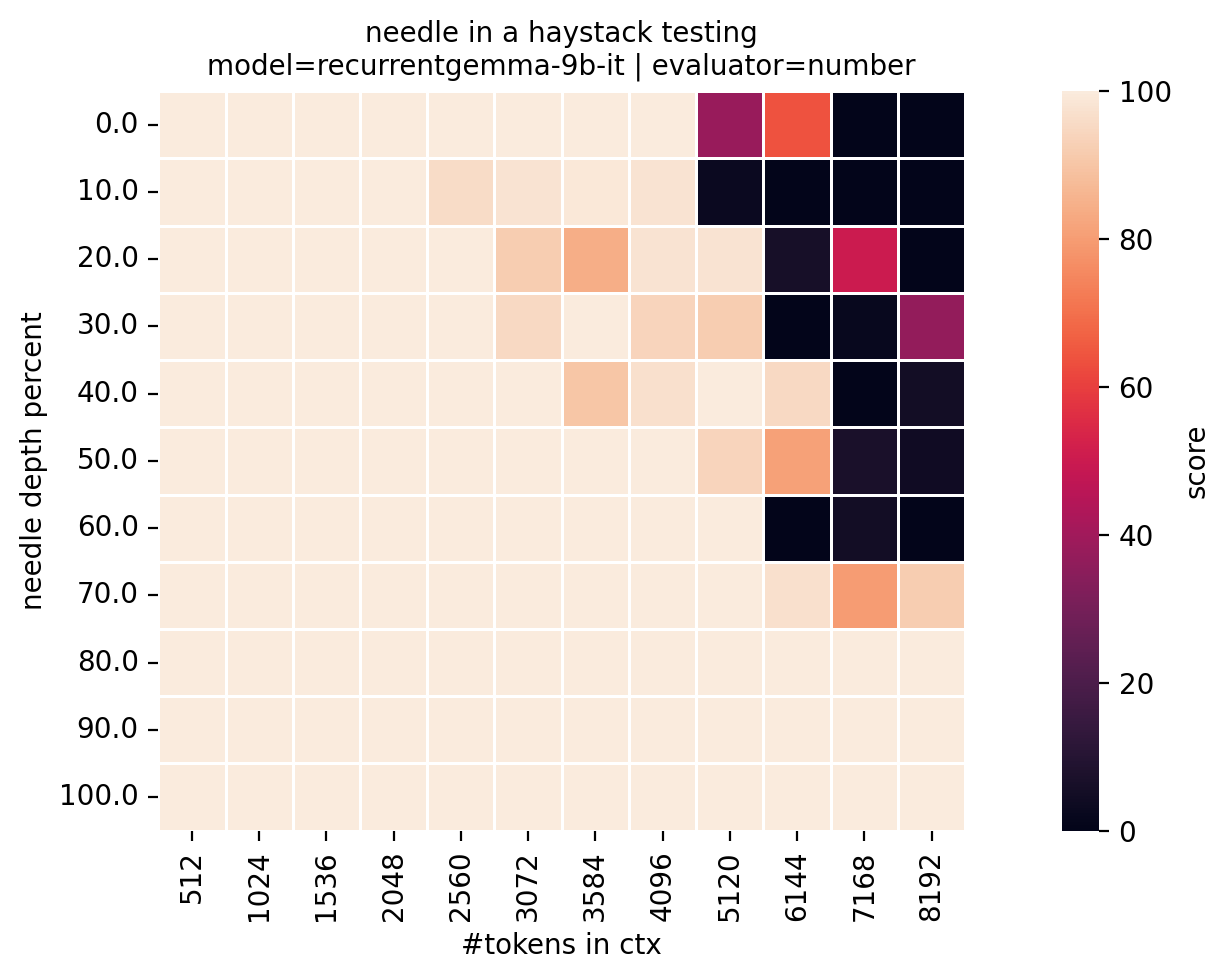

In [8]:
sns.heatmap(pivot_table, fmt="g", cbar_kws={"label": "score"}, square=True, annot=False, linewidth=0.4)

plt.title(
    f"needle in a haystack testing\nmodel=recurrentgemma-{model_name} | evaluator={evaluator_name}", 
    fontsize=10,
)
plt.xlabel("#tokens in ctx")
plt.ylabel("needle depth percent")
plt.tight_layout()

plt.show()